# Classification of Tumor Samples using EM
* Caitlin Dresibach
* Elizabeth Homan
* Morgan Wall

## Import Libraries and Read in the Data

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as st
from scipy.stats import norm,bernoulli
from scipy.optimize import minimize, show_options
from mpl_toolkits.mplot3d import Axes3D
from collections import namedtuple
#from sklearn import mixture
import matplotlib.pyplot as plt
import csv
import math
%matplotlib inline

In [2]:
#Set path
path = 'C:\\Users\\mkw5c\\Documents\\School- spring 2018\\Machine Learning\\midterm project\\'
data = 'data.csv'
labels = 'labels.csv'
rankings = 'rferankings10.txt'

In [3]:
df1 = pd.read_csv(path + data, encoding= "ISO-8859-1", low_memory=False)

In [4]:
labels = pd.read_csv(path + labels, encoding= "ISO-8859-1", low_memory=False)

In [5]:
ranks = pd.read_table(path + rankings, encoding= "ISO-8859-1", low_memory=False, header = None)

## Preprocessing and Data Exploration

In [6]:
# add the class labels to the gene expression data
df1["Class"] = labels["Class"]

In [7]:
df1.head()

,Unnamed: 0,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,...,gene_20522,gene_20523,gene_20524,gene_20525,gene_20526,gene_20527,gene_20528,gene_20529,gene_20530,Class
0,sample_0,0.0,2.017209,3.265527,5.478487,10.431999,0.0,7.175175,0.591871,0.0,...,8.210257,9.723516,7.220030,9.119813,12.003135,9.650743,8.921326,5.286759,0.0,PRAD
1,sample_1,0.0,0.592732,1.588421,7.586157,9.623011,0.0,6.816049,0.000000,0.0,...,7.323865,9.740931,6.256586,8.381612,12.674552,10.517059,9.397854,2.094168,0.0,LUAD
2,sample_2,0.0,3.511759,4.327199,6.881787,9.870730,0.0,6.972130,0.452595,0.0,...,8.127123,10.908640,5.401607,9.911597,9.045255,9.788359,10.090470,1.683023,0.0,PRAD
3,sample_3,0.0,3.663618,4.507649,6.659068,10.196184,0.0,7.843375,0.434882,0.0,...,8.792959,10.141520,8.942805,9.601208,11.392682,9.694814,9.684365,3.292001,0.0,PRAD
4,sample_4,0.0,2.655741,2.821547,6.539454,9.738265,0.0,6.566967,0.360982,0.0,...,8.891425,10.373790,7.181162,9.846910,11.922439,9.217749,9.461191,5.110372,0.0,BRCA


In [8]:
df2 = df1.drop("Unnamed: 0", axis=1)

In [9]:
df2.head()

,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,gene_9,...,gene_20522,gene_20523,gene_20524,gene_20525,gene_20526,gene_20527,gene_20528,gene_20529,gene_20530,Class
0,0.0,2.017209,3.265527,5.478487,10.431999,0.0,7.175175,0.591871,0.0,0.0,...,8.210257,9.723516,7.220030,9.119813,12.003135,9.650743,8.921326,5.286759,0.0,PRAD
1,0.0,0.592732,1.588421,7.586157,9.623011,0.0,6.816049,0.000000,0.0,0.0,...,7.323865,9.740931,6.256586,8.381612,12.674552,10.517059,9.397854,2.094168,0.0,LUAD
2,0.0,3.511759,4.327199,6.881787,9.870730,0.0,6.972130,0.452595,0.0,0.0,...,8.127123,10.908640,5.401607,9.911597,9.045255,9.788359,10.090470,1.683023,0.0,PRAD
3,0.0,3.663618,4.507649,6.659068,10.196184,0.0,7.843375,0.434882,0.0,0.0,...,8.792959,10.141520,8.942805,9.601208,11.392682,9.694814,9.684365,3.292001,0.0,PRAD
4,0.0,2.655741,2.821547,6.539454,9.738265,0.0,6.566967,0.360982,0.0,0.0,...,8.891425,10.373790,7.181162,9.846910,11.922439,9.217749,9.461191,5.110372,0.0,BRCA


In [10]:
ranks.head()

,0
0,19747
1,16579
2,10421
3,7377
4,14640


In [12]:
# create a list of the top 10 genes based on the RFE results, to use for subsetting the full dataset
ranks2 = ranks[ranks[0] == 1]
ranks2.index.name = 'topgenes'
ranks2.reset_index(inplace=True)
ranks2.head()
top_genes = ranks2['topgenes'].tolist()
top_genes.append(20531) # keep the class column
top_genes

[3523, 3541, 3921, 6733, 6876, 7623, 7964, 8598, 9175, 15898, 20531]

In [13]:
# take a subset of the data including all observations, but only the top 10 genes and the class labels

df3 = df2.iloc[:,top_genes]
print(df3.shape)
print(df3.columns)

(801, 11)
Index(['gene_3523', 'gene_3541', 'gene_3921', 'gene_6733', 'gene_6876',
       'gene_7623', 'gene_7964', 'gene_8598', 'gene_9175', 'gene_15898',
       'Class'],
      dtype='object')


In [17]:
# define x and y (features and classes)
x = df3.iloc[:,:10]
y = df3.loc[:,"Class"]
x.head()

,gene_3523,gene_3541,gene_3921,gene_6733,gene_6876,gene_7623,gene_7964,gene_8598,gene_9175,gene_15898
0,1.822037,5.788312,0.591871,2.717803,8.440400,5.663951,5.248778,7.210184,17.173570,1.334282
1,1.327170,13.059513,0.587845,2.592278,6.484409,0.000000,3.890826,2.762370,0.000000,13.609213
2,2.438799,5.155361,0.796598,1.306846,3.352236,1.306846,1.074163,3.677147,14.818422,1.074163
3,1.039419,5.983377,0.000000,0.000000,5.967242,0.000000,2.650029,7.226961,17.371079,0.434882
4,2.678342,8.349648,1.095654,0.360982,13.636772,5.024776,0.000000,10.982102,1.580097,1.095654


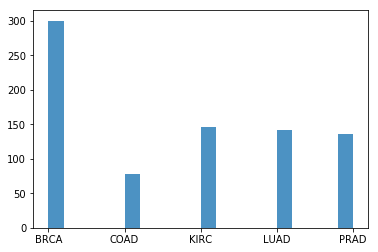

In [18]:
# view a distribution of the class labels
h1 = plt.hist(np.array(df2["Class"]), bins=20,normed=False,histtype='stepfilled',alpha=0.8); 

In [19]:
#  Create a subset of the full dataset for each tumor type (to be used for selecting a random point
#   from each class)

df_prad = df3.loc[df3["Class"] == "PRAD", :]
df_luad = df3.loc[df3["Class"] == "LUAD", :]
df_brca = df3.loc[df3["Class"] == "BRCA", :]
df_kirc = df3.loc[df3["Class"] == "KIRC", :]
df_coad = df3.loc[df3["Class"] == "COAD", :]

## Expectation Maximization Set Up 


In [20]:
# Basic Dimensions

n = 801  #number of samples
d = 10   #number of features
k = 5    #number of clusters


### Initialize the Means (mu)

In [21]:
#choose a random datapoint from each cluster to be the starting mean
mu = []
dfs = [df_prad, df_luad, df_brca, df_kirc, df_coad]
for i in range(5):
    mu_ = dfs[i].iloc[np.random.choice(range(len(dfs[i])), 1, False), :]
    mu.append(mu_)

mu_df = pd.DataFrame(columns = dfs[1].columns)
for i in range(len(mu)):
    mu_df = pd.concat([mu_df, mu[i]])
mu = mu_df.iloc[:, 0:10]
mu

#rename the rows
mu.index = ["PRAD", "LUAD", "BRCA", "KIRC", "COAD"]
mu

,gene_3523,gene_3541,gene_3921,gene_6733,gene_6876,gene_7623,gene_7964,gene_8598,gene_9175,gene_15898
PRAD,1.005903,1.005903,1.329009,0.588900,5.033775,4.437487,8.061576,6.077683,17.071661,0.588900
LUAD,2.441165,14.155625,2.112066,5.899840,8.281480,0.000000,10.084782,2.708938,0.635801,12.680127
BRCA,2.736627,15.741717,1.455807,1.206206,8.247287,7.679086,0.000000,9.715521,3.280288,0.521855
KIRC,2.808488,0.000000,9.788191,6.879350,4.332164,0.000000,10.890241,6.902170,0.459746,0.000000
COAD,12.170035,14.584575,10.695594,4.185930,2.564256,2.660860,9.260369,1.607721,1.607721,0.495183


### Initialize the Covariance (sigma)

In [22]:
#initialize the covariance matrices as identity matrices for each cluster with dimensions dxd
sigma = [np.eye(d)] * k

### Initialize the Class Probabilities

In [23]:
#initialize pi- probability of each class

pi_ = [1./k] * k #equally probable
pi_

[0.2, 0.2, 0.2, 0.2, 0.2]

### Initialize the Responsibility Matrix

In [24]:
# initialize the responsibility function as 0
gamma = np.zeros((n, k))
gamma.shape

(801, 5)

### Define the Probability Distribution Functions
* PDF is the probability of the class of x given theta.  
* mixPDF = sum over all classes [the probability of the class * distribution of the class]
* responsibility function for each sample = PDFk/mixPDF

In [25]:
# define the Probability Distribution Function to be used in the E- step 
# for computing the responsibility function. 

PDF = lambda mu, sigma: np.linalg.det(sigma) ** -.5 ** (2*np.pi) ** (-n/2.)\
        * np.exp(-.5 *np.einsum('ij, ij -> i', x - mu, np.dot(np.linalg.inv(sigma), \
        (x-mu).T).T))

## Run the Expectation Maximization

In [26]:
#initialize a loop

log_likelihoods = []
theta_learning = []
means = []
covar = []
probs = []
threshold = 0.0001
max_iter = 10000
counter = 0
converged = False

while not converged: 
    counter += 1 
    for k_value in range(k):
        
        #-- E- Step
        #---- calculate the responsibility function
        gamma[:, k_value] = pi_[k_value] * PDF(mu.iloc[k_value], sigma[k_value])

        #---- calculate the log likelihood
    log_likelihood = np.sum(np.log(np.sum(gamma, axis = 1)))
    log_likelihoods.append(log_likelihood)

    #---- normalize so that the responsibility matrix is row stochastic
    gamma = (gamma.T /np.sum(gamma, axis = 1)).T

    #---- determine the number of datapoints falling into each distribution
    N_ks = np.sum(gamma, axis = 0)

    for k_value in range(k):
        #-- M- Step
        #---- calculate the new parameters for each Gaussian

        mu.iloc[k_value] = (np.sum(gamma[:, k_value]* x.T, axis = 1).T) / N_ks[k_value]
        x_mu = np.matrix(x- mu.iloc[k_value])

        sigma[k_value] = np.array(np.dot(np.multiply(x_mu.T, gamma[:, k_value]), x_mu)/ N_ks[k_value])

        pi_[k_value] = 1./ n*N_ks[k_value]

    #-- track progress
    theta0 = namedtuple('theta0', ['mu', 'sigma', 'pi_', 'log_likelihood', 'iterations'])
    theta0.mu = mu
    theta0.sigma = sigma
    theta0.pi_ = pi_
    theta0.log_likelihood = log_likelihoods
    theta0.iterations = len(log_likelihoods)
    
    theta_learning.append(theta0)
    means.append(mu)
    covar.append(sigma)
    probs.append(pi_)
    
    
    #-- check for convergence
    if len(log_likelihoods) < 2 : continue
    if np.abs(log_likelihood - log_likelihoods[-2])< threshold: break
    
    # or reached max iterations? 
    converged = counter >= max_iter 
    
params = namedtuple('params', ['mu', 'sigma', 'pi_', 'log_likelihoods', 'num_iters'])
params.mu = mu
params.sigma = sigma
params.pi_ = pi_
params.log_likelihoods = log_likelihoods
params.num_iters = len(log_likelihoods)  
        
print(len(log_likelihoods))
    


9


### View Resulting Parameters

In [27]:
print(params.mu.iloc[0:10, :])
print(params.pi_)

      gene_3523  gene_3541  gene_3921  gene_6733  gene_6876  gene_7623  \
PRAD   1.340056   5.349056   0.731911   1.751508   6.882429   2.558044   
LUAD   2.670100  14.153508   2.106795   3.625453   6.231519   0.623790   
BRCA   2.559154   9.005259   1.056056   1.570165  12.766652   4.679135   
KIRC   1.473396   0.799835   9.584319  12.968026   6.329082   0.251061   
COAD  11.817061  14.480650   9.820895   2.350674   4.530450   4.390389   

      gene_7964  gene_8598  gene_9175  gene_15898  
PRAD   6.735686   6.530793  16.752979    0.742696  
LUAD   8.577297   7.525905   0.879257   15.558813  
BRCA   0.357850   9.957021   1.615781    1.070122  
KIRC  11.178334   6.515465   0.355445    1.011757  
COAD   9.104005   3.601341   1.054822    1.382390  
[0.16978823331575033, 0.17852942849318074, 0.3732803408147411, 0.18102372022276983, 0.097378277153558054]


## Use the Distributions from EM to Predict the Class Labels

In [28]:
# define a function that predicts the probability of each class for each observation using the 
# distribution parameters from the EM model
def predict(x, k):
    p = np.linalg.det(sigma[k]) ** - 0.5 * (2 * np.pi) **\
        (-len(x)/2) * np.exp( -0.5 * np.dot(x - mu.iloc[k] , \
        np.dot(np.linalg.inv(sigma[k]) , (x - mu.iloc[k]).T)))
    prob = pi_[k]*p
    return(prob)

In [29]:
# create a dataframe to store the predicted probabilites for each class
prob_df = pd.DataFrame(index = np.arange(801), columns = ['PRAD', 'LUAD', 'BRCA', 'KIRC', 'COAD'])

In [30]:
# calculate the probabilities of each class for each observation
prob_df['PRAD'] = predict(x, 0)
prob_df['LUAD'] = predict(x, 1)
prob_df['BRCA'] = predict(x, 2)
prob_df['KIRC'] = predict(x, 3)
prob_df['COAD'] = predict(x, 4)

In [31]:
prob_df.head()

,PRAD,LUAD,BRCA,KIRC,COAD
0,3.458460e-323,0.000000e+00,0.000000e+00,0.000000e+00,0.0
1,2.583963e-321,1.027380e-318,0.000000e+00,2.872673e-308,0.0
2,1.047419e-321,0.000000e+00,0.000000e+00,0.000000e+00,0.0
3,7.855644e-322,0.000000e+00,0.000000e+00,0.000000e+00,0.0
4,3.606679e-322,0.000000e+00,2.156102e-320,0.000000e+00,0.0


In [32]:
# take the sum of all of the calculated class probabilities

for i in range(len(prob_df)):
    prob_df.loc[i, 'sum'] = sum(prob_df.iloc[i, 0:5])
prob_df.head()

,PRAD,LUAD,BRCA,KIRC,COAD,sum
0,3.458460e-323,0.000000e+00,0.000000e+00,0.000000e+00,0.0,3.458460e-323
1,2.583963e-321,1.027380e-318,0.000000e+00,2.872673e-308,0.0,2.872673e-308
2,1.047419e-321,0.000000e+00,0.000000e+00,0.000000e+00,0.0,1.047419e-321
3,7.855644e-322,0.000000e+00,0.000000e+00,0.000000e+00,0.0,7.855644e-322
4,3.606679e-322,0.000000e+00,2.156102e-320,0.000000e+00,0.0,2.192169e-320


In [33]:
# divide the probability of each class geiven theta by the sum of the probabilities to get the 
# normalized probability

prob_df["PRAD"] = prob_df["PRAD"]/prob_df['sum']
prob_df["LUAD"] = prob_df["LUAD"]/prob_df['sum']
prob_df["BRCA"] = prob_df["BRCA"]/prob_df['sum']
prob_df["KIRC"] = prob_df["KIRC"]/prob_df['sum']
prob_df["COAD"] = prob_df["COAD"]/prob_df['sum']
prob_df.head()

,PRAD,LUAD,BRCA,KIRC,COAD,sum
0,1.000000e+00,0.000000e+00,0.000000,0.0,0.0,3.458460e-323
1,8.994978e-14,3.576390e-11,0.000000,1.0,0.0,2.872673e-308
2,1.000000e+00,0.000000e+00,0.000000,0.0,0.0,1.047419e-321
3,1.000000e+00,0.000000e+00,0.000000,0.0,0.0,7.855644e-322
4,1.645256e-02,0.000000e+00,0.983547,0.0,0.0,2.192169e-320


In [34]:
# predict the class of each observation by finding the class with the highest probability for each obs.
prob_df['pred'] = prob_df.iloc[:, 0:5].idxmax(axis = 1)
print(prob_df['pred'].value_counts())
print(y.value_counts())

PRAD    391
BRCA    203
KIRC    152
LUAD     43
COAD     12
Name: pred, dtype: int64
BRCA    300
KIRC    146
LUAD    141
PRAD    136
COAD     78
Name: Class, dtype: int64


In [35]:
# initialize columns for the ground truth label and an indicator of whether the prediction is correct
prob_df['groundtruth'] = y
prob_df['correct'] = np.nan

In [36]:
#determine the accuracy

for i in range(801):
    if prob_df.loc[i, 'pred'] == prob_df.loc[i, 'groundtruth']:
        prob_df.loc[i, 'correct'] = 1
    else: 
        prob_df.loc[i, 'correct'] = 0
prob_df.head()

,PRAD,LUAD,BRCA,KIRC,COAD,sum,pred,groundtruth,correct
0,1.000000e+00,0.000000e+00,0.000000,0.0,0.0,3.458460e-323,PRAD,PRAD,1.0
1,8.994978e-14,3.576390e-11,0.000000,1.0,0.0,2.872673e-308,KIRC,LUAD,0.0
2,1.000000e+00,0.000000e+00,0.000000,0.0,0.0,1.047419e-321,PRAD,PRAD,1.0
3,1.000000e+00,0.000000e+00,0.000000,0.0,0.0,7.855644e-322,PRAD,PRAD,1.0
4,1.645256e-02,0.000000e+00,0.983547,0.0,0.0,2.192169e-320,BRCA,BRCA,1.0


In [37]:
# find the total number of correct predictions

total_correct = sum(prob_df['correct'])
total_correct

404.0

In [38]:
# calculate the percentage of correct observations

print('Accuracy of Expectation Maximization classifier on test set: {:.2f}'.format(total_correct/len(prob_df)))

Accuracy of Expectation Maximization classifier on test set: 0.50


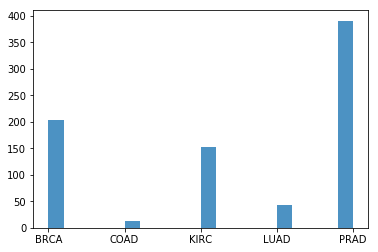

In [39]:
# show distribution of EM predictions
h1 = plt.hist(np.array(prob_df["pred"]), bins=20,normed=False,histtype='stepfilled',alpha=0.8); 